In [1]:
import numpy as np
import imageio as imio
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()

Instructions for updating:
non-resource variables are not supported in the long term


In [54]:
import pandas as pd

Si tienes algún error al ejecutar la celda anterior verifica que tu ambiente de anaconda tenga las librerías necesarias.

# Clasificación con K-nearest neighbors
En este notebook vamos a implementar K-nearest neighbor, nuestro algoritmo va a **clasificar** a que raza pertenece la imagen de un perro, para entrenar nuestro algoritmo vamos a utilizar un set de datos contiene imagenes de 120 razas de perros, en total son 10,222 imagenes.

Data: [Dog Breed Identification](https://www.kaggle.com/c/dog-breed-identification/data)

#### Pre-procesamiento

El pre-procesamiento ya fue realizado y el dataset preparado y esta listo para usarse, para esto se aplico un proceso conocido como "transfer learning" usando la red neuronal "Inception" de Google(tema a cubrirse en proximas clases)  , para esta tarea ignoremos este detalle  y pensemos que se nos da un dataset con features donde cada columna representa una característica de entrada importante,pero no nos interesa conocer los detalles. 

Estas features/características fueron almacenadas en un matriz de numpy.

En esta parte del notebook solo hay que ejecutar las celdas para cargar los datos, estos datos van a servir de entrada para nuestra implementación de K-nearest neighbors con tensorflow.

### Referencias opcionales para transfer learning y "Google inception"
##### Inception
https://www.tensorflow.org/tutorials/image_recognition

https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html

##### Transfer Learning
https://www.datacamp.com/community/tutorials/transfer-learning

In [3]:
images_inception_features = './pre-processing/training_inception_features_array.npy'
training_image_labels_array = './pre-processing/training_image_labels_array.npy'
training_image_names_array = './pre-processing/training_image_names_array.npy'

In [4]:
TRAIN_DICTIONARY_KEYS = ["images", "label","features"]

training_set_dict = dict()
    
training_set_dict['images_name'] = np.load(training_image_names_array, allow_pickle=True)
training_set_dict['label'] = np.load(training_image_labels_array, allow_pickle=True)
training_set_dict['features'] = np.load(images_inception_features, allow_pickle=True)


#  K-Nearest Neighbors

La data la vamos a manejar en los siguientes 3 arreglos: 

- features    : features de la imagen dadas por google Inception
- labels      : label de la imagen, identifica que raza es
- images_name : nombre de la imgen original, si descargan el dataset con link en la descripcion pueden buscar la imagen original por este nombre.

In [5]:
## Cargamos las features y las labes de cada feature
features = training_set_dict['features']
labels = training_set_dict['label']
images_name = training_set_dict['images_name']

In [6]:
len(features)

10222

Las labels pertenecientes a las features tienen el mismo indice, Ejemplo:

Label:  golden_retriever
Nombre:  0021f9ceb3235effd7fcde7f7538ed62


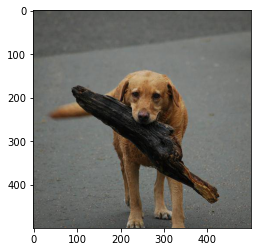

In [7]:
# Indice 4

print('Label: ',labels[4])

print('Nombre: ',images_name[4])

img = imio.imread('./data/train/'+images_name[4]+'.jpg')
plt.imshow(img)


### Implementa tu codigo de  K-Neighbors aqui:

El siguiente es un ejemplo de como puedes  definir tu función para predecir la raza sobre un punto x_predict ,a través de uscar los "k" vecinos mas cercanos en X_train y devolver como predicción el "y" que mas se repite(la moda) correspondiente a esos "k" valores de X_train , este "y" estará dado por Y_train.

Un ejemplo  de KNN en tensorflow: http://marubon-ds.blogspot.com/2017/09/knn-k-nearest-neighbors-by-tensorflow.html (este tiene diferencias, usar como guía no copiar literal, por ejemplo este usa una métrica de distancia diferente a la que debemos usar: distancia euclidiana )


#### Instrucciones:
1. Implementar KNN
2. Agregar el grafo de tensorboard
3. Ejecutar el modelo con las 2 imagenes de prueba.

In [68]:
def predecir_raza_KNN(x_predict,X_train,Y_train,k):
    y = None
    tf.reset_default_graph()
    g = tf.Graph()
    with g.as_default():
        tensor_x = tf.placeholder(dtype=tf.float32,name="X")
        tensor_y = tf.placeholder(dtype=tf.string,name="Y")
        tensor_x_predict = tf.placeholder(dtype=tf.float32,name="X-Predict")

        with tf.name_scope("Euclidean-Distance"):
            distance = tf.math.sqrt(tf.reduce_sum(tf.math.pow(tensor_x_predict - tensor_x, 2), axis=1))
        with tf.name_scope("KNN"):
            indices = tf.argsort(distance, direction='ASCENDING', name="Indexes_NN")
            labels_nn = tf.gather(tensor_y, indices[0:k])  # obtener etiquetas de k vecinos mas cercanos
            y_labels, y_idx, y_count = tf.unique_with_counts(labels_nn)   # obtener conteo de etiquetas
        with tf.name_scope("Prediction"):
            pred_label = tf.gather(y_labels, tf.argmax(y_count), name="Y_hat")     # prediccion de label (etiqueta con mayor conteo)
    with tf.Session(graph=g) as session:
        writer = tf.summary.FileWriter('./graphs/Parte2/KNN', session.graph)
        feed_dict = {tensor_x_predict: x_predict, tensor_x:X_train, tensor_y:Y_train}
        y = session.run([pred_label],feed_dict=feed_dict)

    return y

### Grafo KNN
<img src="./images/Grafo KNN.png">

## Probamos el algoritmo con nuevas imagenes 

Como buena practica luego de entrenar nuestro algoritmo, lo probamos con imagenes que no ha visto antes 

In [12]:
test_features = np.load('./data/test/test_inception_features_array.npy')

### Prueba 1

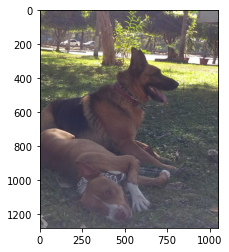

In [13]:
img_test = imio.imread('./data/test/test1.jpg')
plt.imshow(img_test)

In [69]:
predict_image = test_features[0]
y_hat = predecir_raza_KNN(predict_image, features, labels, 15)
print(y_hat)

## Ejecuta tu modelo con la entrada de `predict_image`
# Deberiamos obtener: german_shepherd

[b'german_shepherd']


### Prueba 2

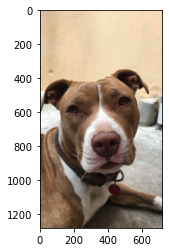

In [64]:
img_test = imio.imread('./data/test/test2.jpg')
plt.imshow(img_test)

In [65]:
## Ejecuta tu modelo con la entrada de `predict_image`
# Deberiamos obtener: american_staffordshire_terrier #
predict_image = test_features[1]
y_hat = predecir_raza_KNN(predict_image, features, labels, 15)
print(y_hat)


[b'american_staffordshire_terrier']
